In [2]:
import pandas as pd
data_30_sentences = pd.read_csv(r'C:\Users\erich\Desktop\DS_project\data\data_30_sentences.csv')

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

def clean_data(df):
    df = df[df['HTML_Content'].isin(['Explicit', 'General Audiences', 'Mature', 'Not Rated', 'Teen And Up Audiences'])]

    df = df.dropna(subset=['TXT_Content'])

    def clean_text(text):

        if not isinstance(text, str):
            text = str(text)

        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        tokenized_text = word_tokenize(text)
        cleaned_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in set(stopwords.words('english'))]

        return ' '.join(cleaned_text)

    df['TXT_Content'] = df['TXT_Content'].apply(clean_text)

    return df

data_30_sentences = clean_data(data_30_sentences)

print(data_30_sentences)

               HTML_Content                                        TXT_Content
0     Teen And Up Audiences  huckleberry finn stood front old wooden door m...
1     Teen And Up Audiences  right huck trying figure every sort way could ...
2         General Audiences  three buried mother christmas eve thing huck c...
3     Teen And Up Audiences  air hot brow wet mind exhausted st petersburg ...
4         General Audiences  episode genre al chaos chaos space time vortex...
...                     ...                                                ...
6036  Teen And Up Audiences  seen news pat asked robin chance hang coat mor...
6037  Teen And Up Audiences  free next friday night murphy smiled phone rob...
6038                 Mature  turned walked away wan na say come baby give w...
6039      General Audiences  perfect word tended apply liberally one often ...
6040                 Mature  heaven fact unlike earth pro con pro include t...

[6005 rows x 2 columns]


In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

df = data_30_sentences
df = df.reset_index(drop=True)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['TXT_Content'])

svd = TruncatedSVD(n_components=2)
reduced_data = svd.fit_transform(tfidf_matrix)

outliers_percent = {}

for label in df['HTML_Content'].unique():
    indices = df[df['HTML_Content'] == label].index
    subset = reduced_data[indices]
    
    mean = np.mean(subset, axis=0)
    std = np.std(subset, axis=0)
    
    outlier_count = ((subset < (mean - 3 * std)) | (subset > (mean + 3 * std))).sum()
    
    percent = (outlier_count / len(indices)) * 100
    outliers_percent[label] = percent

for label, percent in outliers_percent.items():
    print(f"For label '{label}', the percentage of outliers is {percent:.2f}%")

For label 'Teen And Up Audiences', the percentage of outliers is 3.11%
For label 'General Audiences', the percentage of outliers is 3.15%
For label 'Mature', the percentage of outliers is 3.76%
For label 'Explicit', the percentage of outliers is 3.67%
For label 'Not Rated', the percentage of outliers is 2.84%


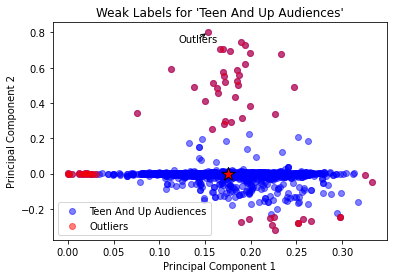

In [29]:
import matplotlib.pyplot as plt
import numpy as np

indices = df[df['HTML_Content'] == "Teen And Up Audiences"].index
subset = reduced_data[indices]

plt.figure(facecolor='white')  

plt.scatter(subset[:, 0], subset[:, 1], c="blue", label="Teen And Up Audiences", alpha=0.5)

cluster_center = np.mean(subset, axis=0)

mean = np.mean(subset, axis=0)
std = np.std(subset, axis=0)
outliers = subset[((subset < (mean - 3 * std)) | (subset > (mean + 3 * std))).any(axis=1)]

if len(outliers) > 0:
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red", label="Outliers", alpha=0.5)
    
    distances = np.linalg.norm(outliers - cluster_center, axis=1)
    outlier = outliers[np.argmax(distances)]
    plt.annotate("Outliers", (outlier[0], outlier[1]), textcoords="offset points", xytext=(-10,-10), ha='center', arrowprops=dict(arrowstyle="->"))

plt.scatter(cluster_center[0], cluster_center[1], c='red', marker='*', s=200, edgecolors='k')

plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Weak Labels for 'Teen And Up Audiences'")
plt.savefig(r'C:\Users\erich\Desktop\DS_project\data\pic\weak_label.png', bbox_inches='tight', facecolor='white')
plt.show()
